# Mn XRD

In [1]:
import numpy as np
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv

In [2]:
wavelength = 0.1542 #nm
lattice_constant = 0.911 #nm
# Primitive Lattice

In [3]:
planes_df = pd.read_csv('All_Planes_hkl.csv')
miller_indices = planes_df.values

In [4]:
# Store this in a dataframe:
miller_list = [list(row) for row in miller_indices[:]]
df = pd.DataFrame({'Miller': miller_list})

In [5]:
df['hkl_squared'] = df['Miller'].apply(lambda x: x[0]**2 + x[1]**2 + x[2]**2)
df['sin theta (rad)'] = df['hkl_squared'].apply(lambda x: math.sqrt((wavelength**2/(4*lattice_constant**2))*x))
df['theta (rad)'] = df['sin theta (rad)'].apply(lambda x:(math.asin(x)))
df['theta (deg)'] = df['theta (rad)'].apply(lambda x: np.rad2deg(x))
df['2 theta (deg)'] = df['theta (deg)'].apply(lambda x: 2 * x)

In [6]:
# check the last 2 theta value, we need enough planes to get to 80 degrees
df['2 theta (deg)'].iloc[-1]

71.79677820944117

In [7]:
def store_atom_positions(csv_name):
    file_path = f"/Users/hendrikvossler/Desktop/GitHub/XRD/{csv_name}"
    
    atom_positions = {}

    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # skip the header
        for row in reader:
            atom_type = row[0]
            coords = list(map(float, row[1:]))
            if atom_type not in atom_positions:
                atom_positions[atom_type] = []
            atom_positions[atom_type].append(coords)

    # Convert lists to numpy arrays
    for atom_type, positions in atom_positions.items():
        atom_positions[atom_type] = np.array(positions)

    return atom_positions

In [8]:
# Read in the atom positions
atom_positions = store_atom_positions('Mn_atom_positions.csv')

In [9]:
# This calculates the term that will be multiplied by the atomic scattering factor
# for each atom type and for each miller incices
def compute_structure_factor_term_i(atom_positions, miller_indices_array):
    results = {}
    
    for miller_indices in miller_indices_array:
        h, k, l = miller_indices
        total = 0
        
        for position in atom_positions:
            #position_adjusted = 2*position # distribute the 2 in the exponential factor to each atom position
            x, y, z = position
            value = x * h + y * k + z * l
            term = np.round(np.exp(2j*np.pi*value), 4)
            total += term
        
        # Store the result with Miller indices as the key
        results[tuple(miller_indices)] = total
    
    return results

In [10]:
Mn_structure_factor_term = compute_structure_factor_term_i(atom_positions["Mn"], miller_indices)
print("Mn", Mn_structure_factor_term)


Mn {(1, 0, 0): (2.220446049250313e-15+1.4432899320127035e-15j), (1, 1, 0): (-0.33360000000000045-1.1102230246251565e-16j), (1, 1, 1): (-6.661338147750939e-15+2.886579864025407e-15j), (2, 0, 0): (-0.18879999999999864-2.220446049250313e-16j), (2, 1, 0): (-2.220446049250313e-16+3.3306690738754696e-16j), (2, 1, 1): (-0.44720000000000026-1.0537999999999983j), (2, 2, 0): (-1.7659999999999996-1.1102230246251565e-16j), (2, 2, 1): (-4.163336342344337e-16+8.881784197001252e-16j), (3, 0, 0): (-5.551115123125783e-16-1.5543122344752192e-15j), (3, 1, 0): (0.4991999999999993+6.245004513516506e-17j), (3, 1, 1): (5.551115123125783e-16-2.220446049250313e-16j), (2, 2, 2): (-2.395199999999999+0.5730000000000026j), (3, 2, 0): (-4.163336342344337e-16+7.771561172376096e-16j), (3, 2, 1): (2.4502000000000006+0.7008j), (4, 0, 0): (-16.9528+2.220446049250313e-16j), (3, 2, 2): (4.440892098500626e-16+5.551115123125783e-16j), (4, 1, 0): (4.440892098500626e-16+5.551115123125783e-16j), (3, 3, 0): (24.053999999999995+

In [11]:
# This calculates f, the atomic scattering factor, for each atom time at each theta angle 
def calc_atomic_scattering_factor(theta, atomic_number, a1, b1, a2, b2, a3, b3, a4=None, b4=None, wavelength = 0.1542):
    s = math.sin(theta)/(wavelength*10)
    f = atomic_number - (41.78214 * s**2) * (a1*np.e**(-b1*s**2) + a2*np.e**(-b2*s**2) + a3*np.e**(-b3*s**2) + a4*np.e**(-b4*s**2))
    return f

In [12]:
# Populate df with atomic scattering factors
df['Mn_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 25, 2.747, 67.786, 2.456, 15.674, 1.792, 3, 0.498, 0.357))

In [13]:
# Define function to calculate multiplicity facor for each plane:
def get_unique_permutations(hkl):
    # Get all permutations of the Miller indices
    perms = list(itertools.permutations(hkl))
    
    # For each permutation, consider all possible sign changes
    all_permutations = []
    for perm in perms:
        signs = itertools.product([1, -1], repeat=3)
        for sign in signs:
            all_permutations.append(tuple([i*j for i, j in zip(perm, sign)]))
    
    # Return unique permutations (number of planes in family)
    return set(all_permutations)

In [14]:
# Calculate the structure factors using the atomic scattering factors- 
# i need to go through this math to make sure it is correct- 
# it definitely doesnt match the peak intensities given on materials project
#this is definitely where the error is- adding up the structure factor- it works for single atom but not for multiple atoms
df['Structure Factor'] = (df['Mn_f'] * df['Miller'].apply(lambda x: Mn_structure_factor_term[tuple(x)])) 
df['conj'] = df['Structure Factor'].apply(lambda x: np.conj(x))
result = (df["Structure Factor"]*df['conj'])
df['F^2'] = result.apply(lambda x: x.real)
df['p'] = df['Miller'].apply(lambda x: len(get_unique_permutations(x)))
df['Lorentz_factor'] = df['theta (rad)'].apply(lambda x: (1+(math.cos(2*x)**2)) / (math.sin(x)**2 * math.cos(x)))
df['Intensity'] = df['F^2']*df['p']*df['Lorentz_factor']
df["Intensity_norm"] = (df["Intensity"]*100/df["Intensity"].max())


In [15]:
# what do i do when two planes have the same 2 theta value and both diffract? do you add the intensities?
# on materials project, 1 0 0 and 210 both dont even show up??

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

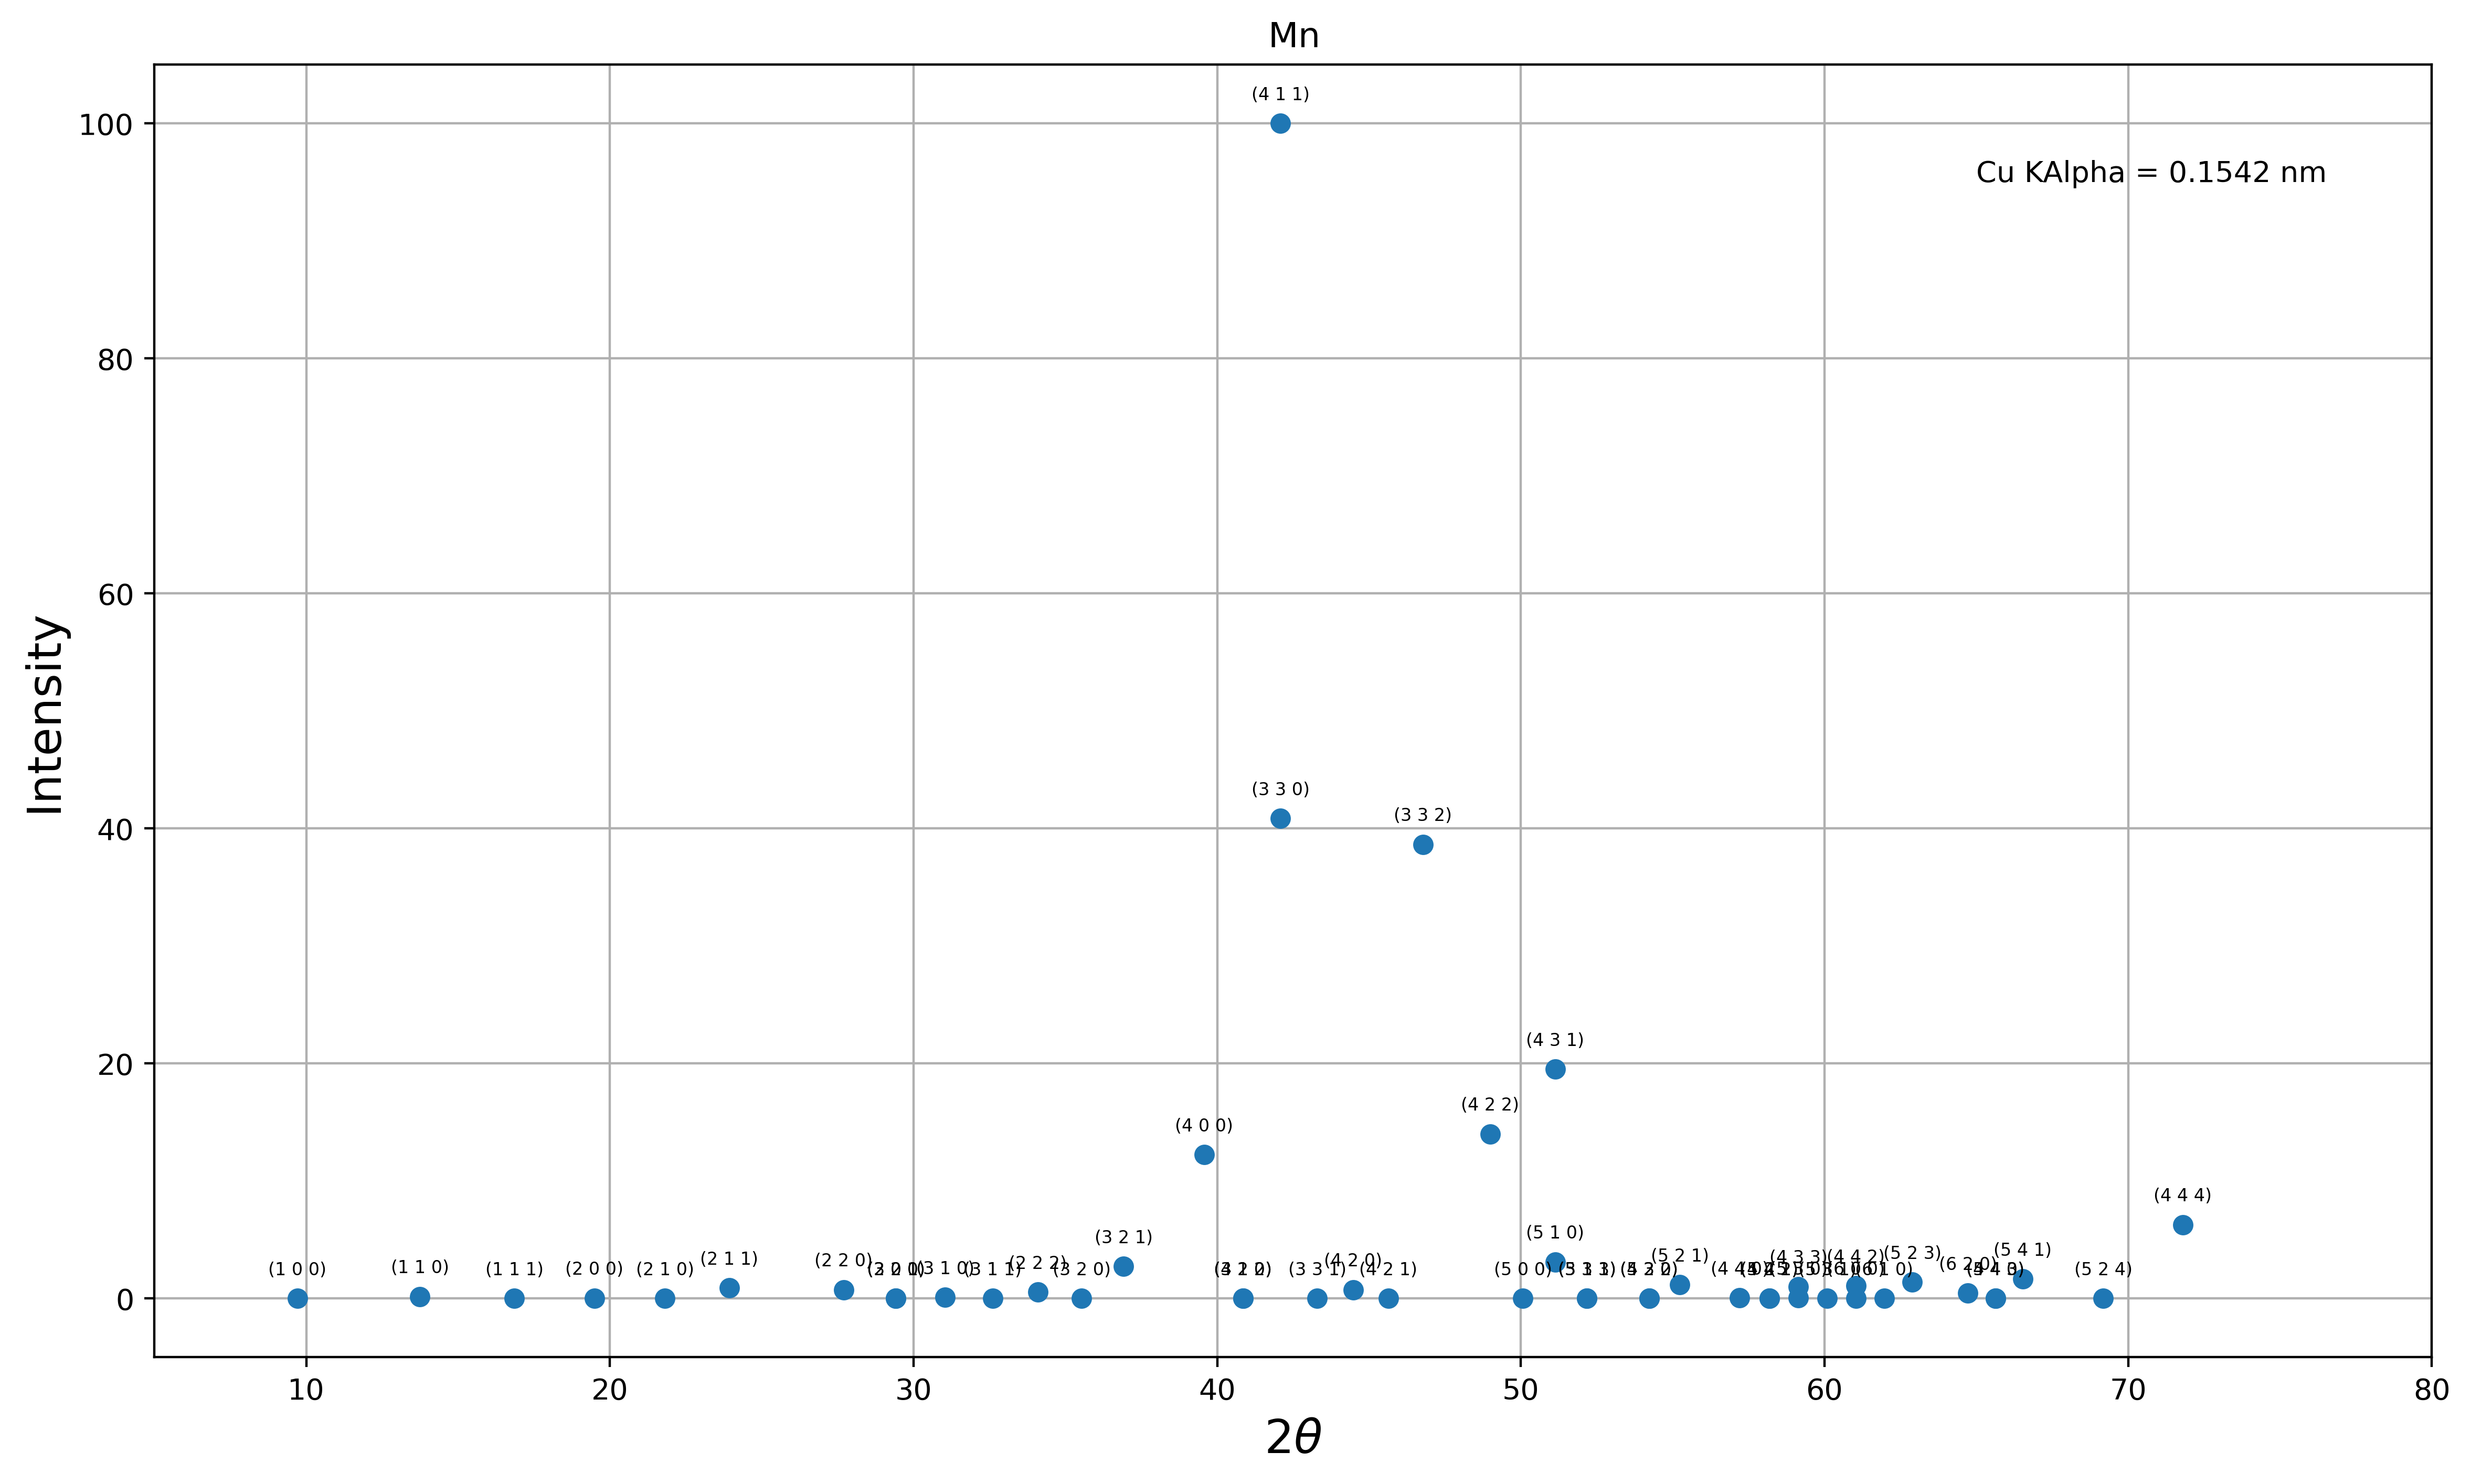

In [16]:
# Plot the XRD pattern
# Filter out forbidden reflections
fig = plt.figure(figsize=(14, 8), dpi = 400)
filtered_df = df[df['Intensity_norm'] != 0]
x = filtered_df['2 theta (deg)']
y = filtered_df['Intensity_norm']
plt.plot(x, y, 'o')

# Add text labels above each data point
for index, row in filtered_df.iterrows():
    label = str(row['Miller']).replace('[', '(').replace(']', ')').replace(',', '')
    x = row['2 theta (deg)']
    y = row['Intensity_norm']
    plt.text(x, y + 0.02 * max(filtered_df['Intensity_norm']), label, ha='center', fontsize=6)

# Figure formatting
plt.text(65, 95, "Cu KAlpha = 0.1542 nm")
plt.xlim(5, 80)
plt.xlabel("2"r'$\theta$', fontsize = 16)
plt.ylabel('Intensity', fontsize = 16)
plt.title(r'$\mathrm{Mn}$')
plt.grid()
plt.tight_layout


In [17]:
df.loc[:, ['Miller', "Intensity_norm"]]

,Miller,Intensity_norm
0,"[1, 0, 0]",9.640553e-30
1,"[1, 1, 0]",1.423625e-01
2,"[1, 1, 1]",2.809107e-29
3,"[2, 0, 0]",1.007689e-02
4,"[2, 1, 0]",1.373257e-31
5,"[2, 1, 1]",8.899544e-01
6,"[2, 2, 0]",7.241457e-01
7,"[2, 2, 1]",3.804376e-31
8,"[3, 0, 0]",2.692609e-31
9,"[3, 1, 0]",8.507519e-02
